# Evo-Bayes-Agent

I use `bayesian-optimization==0.6`, my backend pretty much stick with this version, so migrating will break the code.

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()

In [2]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

TSLA Time Period: **Mar 23, 2018 - Mar 23, 2019**

In [3]:
from Ionomy import IonPanda, BitTA
from decouple import config

MARKET = 'btc-hive'
CURRENCY = 'hive'
BASE = 'btc'
TIME = 'day'

bta = BitTA(config('TREX_KEY'), config('TREX_SECRET'))
ionpd = IonPanda(config('ION_KEY'), config('ION_SECRET'))
bta.update(CURRENCY, BASE, TIME)

df = bta.df

In [4]:
close = df.close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [5]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [6]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [7]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(100, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [8]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [9]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 50),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Search parameters {'window_size': 50, 'skip': 8, 'population_size': 20, 'sigma': 0.7216533365479368, 'learning_rate': 0.12229693844523727, 'size_network': 814}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  1        |  0.0      |  0.1223   |  20.03    |  0.7217   |  814.3    |  7.877    |  49.6     |

Search parameters {'window_size': 11, 'skip': 7, 'population_size': 33, 'sigma': 0.6898441909513964, 'learning_rate': 0.35206865481050803, 'size_network': 945}
stop after 100 iteration with investment 0.000000
|  2        |  0.0      |  0.3521   |  33.35    |  0.6898   |  945.1    |  6.781    |  10.85    |

Search parameters {'window_size': 8, 'skip': 5, 'population_size': 45, 'sigma': 0.4433138142416959, 'learning_rate': 0.25689803667261046, 'size_network': 529}
stop after 100 iteration with investment 0.000000
|  3        |  0.0      |  0.2569   |  44.59    |  0.4433   |  529.2    |  4.978    |  7.801    |

Search parameters {'window_size': 41, 'skip': 3, 'population_size': 23, 'sigma': 0.7572252248144582, 'learning_rate': 0.14230379287098152, 'size_network': 353}
stop after 100 iteration with investment 0.000000
|  4        |  0.0      

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 22, 'skip': 6, 'population_size': 13, 'sigma': 0.5216378063268913, 'learning_rate': 0.3406793467632621, 'size_network': 634}
stop after 100 iteration with investment 0.000000
|  32       |  0.0      |  0.3407   |  13.26    |  0.5216   |  634.4    |  5.917    |  22.45    |

Search parameters {'window_size': 13, 'skip': 3, 'population_size': 16, 'sigma': 0.9203314215149242, 'learning_rate': 0.001676358253168024, 'size_network': 313}
stop after 100 iteration with investment 0.000000
|  33       |  0.0      |  0.001676 |  16.02    |  0.9203   |  312.8    |  3.338    |  12.78    |


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 2, 'skip': 10, 'population_size': 40, 'sigma': 0.239749551013616, 'learning_rate': 0.30984216770275846, 'size_network': 589}
stop after 100 iteration with investment 0.000000
|  34       |  0.0      |  0.3098   |  40.23    |  0.2397   |  589.5    |  10.16    |  2.478    |

Search parameters {'window_size': 6, 'skip': 5, 'population_size': 21, 'sigma': 0.5313705574311927, 'learning_rate': 0.16606852500810224, 'size_network': 640}
stop after 100 iteration with investment 0.000000
|  35       |  0.0      |  0.1661   |  20.65    |  0.5314   |  640.0    |  4.571    |  6.266    |


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 26, 'skip': 8, 'population_size': 39, 'sigma': 0.3065020327260903, 'learning_rate': 0.3617191997179383, 'size_network': 44}
stop after 100 iteration with investment 0.000000
|  36       |  0.0      |  0.3617   |  39.46    |  0.3065   |  43.86    |  8.382    |  25.53    |

Search parameters {'window_size': 26, 'skip': 10, 'population_size': 30, 'sigma': 0.3303917842998136, 'learning_rate': 0.401995401908722, 'size_network': 818}
stop after 100 iteration with investment 0.000000
|  37       |  0.0      |  0.402    |  29.86    |  0.3304   |  817.5    |  10.12    |  26.04    |


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 38, 'skip': 12, 'population_size': 34, 'sigma': 0.6110172319621642, 'learning_rate': 0.2899727892883361, 'size_network': 799}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  38       |  0.0      |  0.29     |  33.82    |  0.611    |  798.8    |  11.58    |  38.2     |

Search parameters {'window_size': 18, 'skip': 10, 'population_size': 43, 'sigma': 0.32765372289052663, 'learning_rate': 0.15014605707510692, 'size_network': 800}
stop after 100 iteration with investment 0.000000
|  39       |  0.0      |  0.1501   |  42.69    |  0.3277   |  800.3    |  10.18    |  17.77    |

Search parameters {'window_size': 22, 'skip': 5, 'population_size': 21, 'sigma': 0.10564579993251402, 'learning_rate': 0.06683224597919946, 'size_network': 799}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  40       |  0.0      |  0.06683  |  20.93    |  0.1056   |  799.1    |  4.704    |  22.16    |

Search parameters {'window_size': 44, 'skip': 6, 'population_size': 17, 'sigma': 0.14164585684791842, 'learning_rate': 0.18372880288778054, 'size_network': 790}
stop after 100 iteration with investment 0.000000
|  41       |  0.0      |  0.1837   |  16.94    |  0.1416   |  789.7    |  6.202    |  44.41    |

Search parameters {'window_size': 30, 'skip': 4, 'population_size': 34, 'sigma': 0.7029637240312148, 'learning_rate': 0.0727653392507426, 'size_network': 779}
stop after 100 iteration with investment 0.000000
|  42       |  0.0      |  0.07277  |  33.77    |  0.703    |  778.5    |  4.178    |  29.92    |

Search parameters {'window_size': 37, 'skip': 9, 'population_size': 23, 'sigma': 0.6010261425273637, 'learning_rate': 0.19431063090741676, 'size_network': 970}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  43       |  0.0      |  0.1943   |  22.99    |  0.601    |  969.9    |  8.85     |  36.91    |

Search parameters {'window_size': 21, 'skip': 3, 'population_size': 25, 'sigma': 0.21450457816646237, 'learning_rate': 0.3636090006847911, 'size_network': 642}
stop after 100 iteration with investment 0.000000
|  44       |  0.0      |  0.3636   |  25.23    |  0.2145   |  642.4    |  3.167    |  20.52    |

Search parameters {'window_size': 40, 'skip': 1, 'population_size': 32, 'sigma': 0.30366916514150005, 'learning_rate': 0.2666982000319076, 'size_network': 951}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  45       |  0.0      |  0.2667   |  31.75    |  0.3037   |  951.4    |  1.001    |  39.87    |

Search parameters {'window_size': 20, 'skip': 5, 'population_size': 22, 'sigma': 0.6985683890271893, 'learning_rate': 0.35043871623539957, 'size_network': 554}
stop after 100 iteration with investment 0.000000
|  46       |  0.0      |  0.3504   |  22.35    |  0.6986   |  554.2    |  5.357    |  19.77    |

Search parameters {'window_size': 16, 'skip': 5, 'population_size': 7, 'sigma': 0.8716397248543463, 'learning_rate': 0.3059404660411989, 'size_network': 570}
stop after 100 iteration with investment 0.000000
|  47       |  0.0      |  0.3059   |  7.123    |  0.8716   |  570.1    |  5.044    |  15.91    |

Search parameters {'window_size': 23, 'skip': 2, 'population_size': 38, 'sigma': 0.542404166213175, 'learning_rate': 0.28313393828878225, 'size_network': 969}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  48       |  0.0      |  0.2831   |  38.11    |  0.5424   |  968.9    |  2.037    |  23.21    |

Search parameters {'window_size': 7, 'skip': 14, 'population_size': 50, 'sigma': 0.6549549380422739, 'learning_rate': 0.4237863072961676, 'size_network': 582}
stop after 100 iteration with investment 0.000000
|  49       |  0.0      |  0.4238   |  49.97    |  0.655    |  581.8    |  14.38    |  6.513    |


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 7, 'skip': 4, 'population_size': 31, 'sigma': 0.8308787207352996, 'learning_rate': 0.23470082526967537, 'size_network': 51}
stop after 100 iteration with investment 0.000000
|  50       |  0.0      |  0.2347   |  31.27    |  0.8309   |  50.97    |  3.562    |  6.648    |

Search parameters {'window_size': 33, 'skip': 15, 'population_size': 18, 'sigma': 0.7246310627982474, 'learning_rate': 0.3669471325251037, 'size_network': 317}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  51       |  0.0      |  0.3669   |  17.99    |  0.7246   |  316.5    |  14.67    |  33.41    |

Search parameters {'window_size': 28, 'skip': 3, 'population_size': 35, 'sigma': 0.6897119861998772, 'learning_rate': 0.3476905911066704, 'size_network': 305}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  52       |  0.0      |  0.3477   |  35.2     |  0.6897   |  304.8    |  2.779    |  28.39    |

Search parameters {'window_size': 32, 'skip': 3, 'population_size': 35, 'sigma': 0.3211255462430628, 'learning_rate': 0.4849072580653903, 'size_network': 332}
stop after 100 iteration with investment 0.000000
|  53       |  0.0      |  0.4849   |  35.03    |  0.3211   |  332.1    |  3.471    |  32.07    |

Search parameters {'window_size': 29, 'skip': 9, 'population_size': 11, 'sigma': 0.44640004292389507, 'learning_rate': 0.15421751280734128, 'size_network': 337}
stop after 100 iteration with investment 0.000000
|  54       |  0.0      |  0.1542   |  10.64    |  0.4464   |  337.1    |  9.203    |  28.66    |

Search parameters {'window_size': 47, 'skip': 2, 'population_size': 16, 'sigma': 0.3460192825149072, 'learning_rate': 0.21923193145537648, 'size_network': 330}
stop after 100 iteration with investment 0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


|  55       |  0.0      |  0.2192   |  15.56    |  0.346    |  330.5    |  1.878    |  46.88    |

Search parameters {'window_size': 9, 'skip': 1, 'population_size': 11, 'sigma': 0.20058510669552446, 'learning_rate': 0.14087066160901507, 'size_network': 623}
stop after 100 iteration with investment 0.000000
|  56       |  0.0      |  0.1409   |  11.09    |  0.2006   |  622.8    |  1.323    |  8.82     |


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 49, 'skip': 5, 'population_size': 34, 'sigma': 0.8351645816524863, 'learning_rate': 0.13367041058333953, 'size_network': 312}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  57       |  0.0      |  0.1337   |  34.15    |  0.8352   |  312.0    |  5.139    |  49.04    |

Search parameters {'window_size': 50, 'skip': 15, 'population_size': 34, 'sigma': 0.16709459246842362, 'learning_rate': 0.05792766692876186, 'size_network': 340}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  58       |  0.0      |  0.05793  |  33.59    |  0.1671   |  340.2    |  14.69    |  49.65    |

Search parameters {'window_size': 45, 'skip': 7, 'population_size': 44, 'sigma': 0.35625054176685517, 'learning_rate': 0.02401322916498422, 'size_network': 982}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  59       |  0.0      |  0.02401  |  43.89    |  0.3563   |  982.4    |  6.649    |  45.43    |

Search parameters {'window_size': 16, 'skip': 9, 'population_size': 27, 'sigma': 0.34712654939117904, 'learning_rate': 0.3445394550868205, 'size_network': 72}
stop after 100 iteration with investment 0.000000
|  60       |  0.0      |  0.3445   |  26.75    |  0.3471   |  71.65    |  9.166    |  16.18    |

Search parameters {'window_size': 6, 'skip': 5, 'population_size': 43, 'sigma': 0.2540942191469858, 'learning_rate': 0.4336383528603795, 'size_network': 90}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  61       |  0.0      |  0.4336   |  43.08    |  0.2541   |  89.67    |  4.505    |  5.962    |

Search parameters {'window_size': 23, 'skip': 13, 'population_size': 32, 'sigma': 0.8698241411902563, 'learning_rate': 0.39143540010918965, 'size_network': 97}
stop after 100 iteration with investment 0.000000
|  62       |  0.0      |  0.3914   |  32.11    |  0.8698   |  96.6     |  13.43    |  23.19    |

Search parameters {'window_size': 4, 'skip': 8, 'population_size': 19, 'sigma': 0.7683224708961104, 'learning_rate': 0.20441476064731154, 'size_network': 100}
stop after 100 iteration with investment 0.000000
|  63       |  0.0      |  0.2044   |  18.57    |  0.7683   |  99.73    |  8.178    |  4.391    |

Search parameters {'window_size': 42, 'skip': 14, 'population_size': 28, 'sigma': 0.49953337976605483, 'learning_rate': 0.3679634093007279, 'size_network': 76}
stop after 100 iteration with investment 0.000000
|  64       |  0.0      

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 31, 'skip': 1, 'population_size': 11, 'sigma': 0.9404871138958676, 'learning_rate': 0.3673735199554435, 'size_network': 90}
stop after 100 iteration with investment 0.000000
|  65       |  0.0      |  0.3674   |  11.36    |  0.9405   |  89.69    |  1.09     |  31.17    |

Search parameters {'window_size': 25, 'skip': 9, 'population_size': 15, 'sigma': 0.9217441976581927, 'learning_rate': 0.41999558674717397, 'size_network': 117}
stop after 100 iteration with investment 0.000000
|  66       |  0.0      |  0.42     |  15.23    |  0.9217   |  117.1    |  8.658    |  25.24    |


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 40, 'skip': 1, 'population_size': 44, 'sigma': 0.16702517168364017, 'learning_rate': 0.06930286124787167, 'size_network': 89}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  67       |  0.0      |  0.0693   |  43.89    |  0.167    |  88.82    |  1.205    |  40.43    |

Search parameters {'window_size': 48, 'skip': 8, 'population_size': 19, 'sigma': 0.4391776668220252, 'learning_rate': 0.3947012035538806, 'size_network': 106}
stop after 100 iteration with investment 0.000000
|  68       |  0.0      |  0.3947   |  19.37    |  0.4392   |  105.8    |  7.83     |  48.45    |

Search parameters {'window_size': 32, 'skip': 3, 'population_size': 38, 'sigma': 0.3049733668375257, 'learning_rate': 0.33534252165363787, 'size_network': 114}
stop after 100 iteration with investment 0.000000
|  69       |  0.0      |  0.3353   |  37.75    |  0.305    |  114.0    |  2.627    |  31.77    |

Search parameters {'window_size': 49, 'skip': 7, 'population_size': 27, 'sigma': 0.4213304411145385, 'learning_rate': 0.14093412429613827, 'size_network': 130}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  70       |  0.0      |  0.1409   |  26.86    |  0.4213   |  129.7    |  7.247    |  48.93    |

Search parameters {'window_size': 27, 'skip': 3, 'population_size': 28, 'sigma': 0.6613072248645855, 'learning_rate': 0.3917481088452156, 'size_network': 139}
stop after 100 iteration with investment 0.000000
|  71       |  0.0      |  0.3917   |  27.72    |  0.6613   |  138.9    |  3.062    |  26.81    |

Search parameters {'window_size': 37, 'skip': 5, 'population_size': 5, 'sigma': 0.3447935339253173, 'learning_rate': 0.07160612556327062, 'size_network': 137}
stop after 100 iteration with investment 0.000000
|  72       |  0.0      |  0.07161  |  4.752    |  0.3448   |  136.8    |  4.513    |  36.72    |

Search parameters {'window_size': 49, 'skip': 4, 'population_size': 38, 'sigma': 0.07848906588963889, 'learning_rate': 0.2385953117205321, 'size_network': 55}
stop after 100 iteration with investment 0.000000
|  73       |  0.0      | 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 17, 'skip': 1, 'population_size': 17, 'sigma': 0.24261762548897242, 'learning_rate': 0.25087331077485364, 'size_network': 984}
stop after 100 iteration with investment 0.000000
|  74       |  0.0      |  0.2509   |  16.61    |  0.2426   |  984.2    |  1.479    |  16.53    |


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 19, 'skip': 5, 'population_size': 40, 'sigma': 0.5266412473604217, 'learning_rate': 0.29449405718645666, 'size_network': 995}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  75       |  0.0      |  0.2945   |  39.63    |  0.5266   |  994.8    |  5.43     |  18.74    |

Search parameters {'window_size': 4, 'skip': 13, 'population_size': 29, 'sigma': 0.46319396918036915, 'learning_rate': 0.38215424052265257, 'size_network': 976}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
|  76       |  0.0      |  0.3822   |  28.71    |  0.4632   |  976.3    |  12.81    |  4.455    |

Search parameters {'window_size': 41, 'skip': 6, 'population_size': 13, 'sigma': 0.13952372614976039, 'learning_rate': 0.24921393424243998, 'size_network': 561}
stop after 100 iteration with investment 0.000000
|  77       |  0.0      |  0.2492   |  12.65    |  0.1395   |  561.2    |  6.281    |  41.26    |

Search parameters {'window_size': 48, 'skip': 1, 'population_size': 11, 'sigma': 0.1954754298624752, 'learning_rate': 0.31407586833391277, 'size_network': 68}
stop after 100 iteration with investment 0.000000
|  78       |  0.0      |  0.3141   |  10.57    |  0.1955   |  67.58    |  1.446    |  48.09    |

Search parameters {'window_size': 42, 'skip': 5, 'population_size': 23, 'sigma': 0.2181757454069817, 'learning_rate': 0.09981794655052079, 'size_network': 30}
stop after 100 iteration with investment 0.000000
|  79       |  0.0      

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 5, 'skip': 4, 'population_size': 9, 'sigma': 0.715382824664753, 'learning_rate': 0.15708453424507746, 'size_network': 129}
stop after 100 iteration with investment 0.000000
|  80       |  0.0      |  0.1571   |  8.586    |  0.7154   |  129.4    |  3.837    |  4.853    |


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [10]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

TypeError: list indices must be integers or slices, not str

In [11]:
df = pd.DataFrame.from_records([{"target": item["target"], **item["params"]} for item in NN_BAYESIAN.res])

In [12]:
best_params = df.iloc[df['target'].idxmax()].to_dict()
best_params

{'target': 0.0,
 'learning_rate': 0.12229693844523727,
 'population_size': 20.025408761055512,
 'sigma': 0.7216533365479368,
 'size_network': 814.3491677229351,
 'skip': 7.876673951246091,
 'window_size': 49.60021789585117}

#### My selected parameters

In [21]:
best_agent(
    window_size = 30, 
    skip = 1, 
    population_size = 15, 
    sigma = 0.1, 
    learning_rate = 0.03, 
    size_network = 500
)

time taken to train: 16.147530555725098 seconds


62.18609479000003

#### bayesian parameters

In [29]:
best_agent(
    window_size = int(np.around(best_params['window_size'])), 
    skip = int(np.around(best_params['skip'])), 
    population_size = int(np.around(best_params['population_size'])), 
    sigma = best_params['sigma'], 
    learning_rate = best_params['learning_rate'], 
    size_network = int(np.around(best_params['size_network']))
)

time taken to train: 34.824726819992065 seconds


118.85879700000001

#### My selected parameters

In [31]:
# model = Model(input_size = 30, 
#               layer_size = 500, 
#               output_size = 3)
# agent = Agent(population_size = 15, 
#               sigma = 0.1, 
#               learning_rate = 0.03, 
#               model = model, 
#               money = 10000, 
#               max_buy = 5, 
#               max_sell = 5, 
#               skip = 1, 
#               window_size = 30)
# agent.fit(500, 100)
# agent.buy()

#### bayesian parameters

iter 100. reward: 125.126609
iter 200. reward: 134.251206
iter 300. reward: 136.423405
iter 400. reward: 138.313806
iter 500. reward: 139.142707
time taken to train: 164.1535506248474 seconds
day 0: buy 5 units at price 1507.700045, total balance 8492.299955
day 1, sell 5 units at price 1520.899965, investment 0.875500 %, total balance 10013.199920,
day 2: buy 5 units at price 1395.899965, total balance 8617.299955
day 3: buy 5 units at price 1288.899995, total balance 7328.399960
day 4: buy 5 units at price 1330.650025, total balance 5997.749935
day 5: buy 5 units at price 1262.399980, total balance 4735.349955
day 6: buy 5 units at price 1337.649995, total balance 3397.699960
day 7: buy 5 units at price 1434.700010, total balance 1962.999950
day 9: buy 1 units at price 299.299988, total balance 1663.699962
day 10: buy 1 units at price 289.660004, total balance 1374.039958
day 11, sell 5 units at price 1523.500060, investment 9.141063 %, total balance 2897.540018,
day 12, sell 5 units

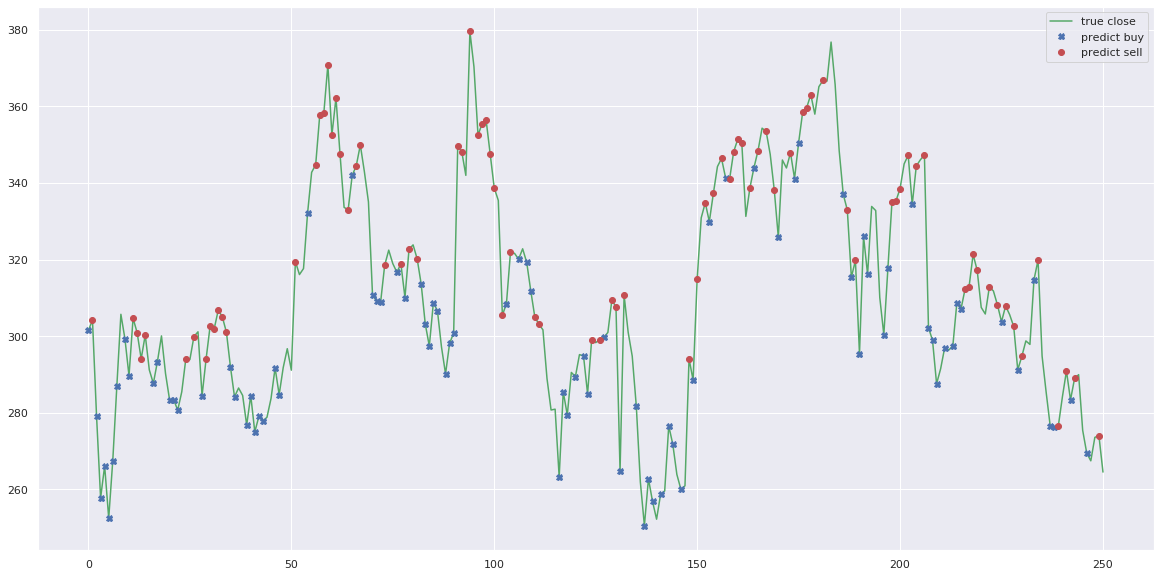

In [32]:
model = Model(input_size = int(np.around(best_params['window_size'])), 
              layer_size = int(np.around(best_params['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(best_params['population_size'])), 
              sigma = best_params['sigma'], 
              learning_rate = best_params['learning_rate'], 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = int(np.around(best_params['skip'])), 
              window_size = int(np.around(best_params['window_size'])))
agent.fit(500, 100)
agent.buy()